In [23]:
## Variables

In [24]:
srr_name <- "SRR5090597"
donor_name <- "hpv16"
recipient_name <- "USCShg38"
inputs_folder <- "../../wallaby/workflows/cromwell-final-outputs/"
donor_ref_genome <- "../../wallaby/data/ref_genomes/hpv/HPV16.fasta"
recipient_ref_genome <- "../../wallaby/data/ref_genomes/human/USCS.hg38.fasta"

# Tertiary analysis of a Donor-to-Recipient pipeline

In [25]:
## Setup Environment

In [26]:
# Enable multithreading when possible (library dependent)
options(Ncpus = parallel::detectCores())
Sys.setenv(OMP_NUM_THREADS=toString(parallel::detectCores()))
Sys.setenv(OMP_THREAD_LIMIT=toString(parallel::detectCores()))
Sys.setenv(OMP_NUM_THREADS=parallel::detectCores())
Sys.setenv(OMP_THREAD_LIMIT=parallel::detectCores())

# Install tricky packages
library(BSgenome.Hsapiens.UCSC.hg38)

## Load or install and load all libraries
packages = c("pacman", "BiocManager", "XML")
package.check <- lapply(
    packages,
    FUN = function(x) {
        if (!require(x, character.only = TRUE)) {
          supressMessages(install.packages(x, dependencies = TRUE))
          suppressPackageStartupMessages(library(x, character.only = TRUE))
        }
    }
)


# List of CRAN packages to either Load, or Install and Load
pacman::p_load(dplyr, 
               ggplot2,
               shiny,
               shinyLP,
               DT, 
               ggrepel, 
               tidyr,
               data.table,
               kableExtra,
               knitr,
               IRdisplay)

# List of Bioconductor packages to either Load, or Install and Load
pacman::p_load(GenomicFeatures,
               GenomicAlignments, 
               Rsubread, 
               Rsamtools,
               bamsignals, 
               rtracklayer,
               GenomicRanges,
               TxDb.Hsapiens.UCSC.hg38.knownGene, 
               regioneR,
               karyoploteR, 
               seqinr,
               Repitools)

In [27]:
## Helper Functions

In [28]:
## Loading pipeline output files
# Try to open all files - note that some will not exists as that specific crossing bucket did not return any matches

In [29]:
# Variables to hold all file paths  
try(donor_MMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MMr.bam", sep = ""))
try(donor_MMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MUr.bam", sep = ""))
try(donor_MMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UMr.bam", sep = ""))
try(donor_MMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UUr.bam", sep = ""))
try(donor_MUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MMr.bam", sep = ""))
try(donor_MUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MUr.bam", sep = ""))
try(donor_MUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UMr.bam", sep = ""))
try(donor_MUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UUr.bam", sep = ""))
try(donor_UMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MMr.bam", sep = ""))
try(donor_UMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MUr.bam", sep = ""))
try(donor_UMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UMr.bam", sep = ""))
try(donor_UMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UUr.bam", sep = ""))
try(donor_UUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MMr.bam", sep = ""))
try(donor_UUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MUr.bam", sep = ""))
try(donor_UUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UMr.bam", sep = ""))
try(donor_UUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UUr.bam", sep = ""))

In [30]:
# Variables to hold all file paths  
try(recip_MMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MMr.bam", sep = ""))
try(recip_MMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MUr.bam", sep = ""))
try(recip_MMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UMr.bam", sep = ""))
try(recip_MMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UUr.bam", sep = ""))
try(recip_MUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MMr.bam", sep = ""))
try(recip_MUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MUr.bam", sep = ""))
try(recip_MUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UMr.bam", sep = ""))
try(recip_MUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UUr.bam", sep = ""))
try(recip_UMd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MMr.bam", sep = ""))
try(recip_UMd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MUr.bam", sep = ""))
try(recip_UMd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UMr.bam", sep = ""))
try(recip_UMd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UUr.bam", sep = ""))
try(recip_UUd_MMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MMr.bam", sep = ""))
try(recip_UUd_MUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MUr.bam", sep = ""))
try(recip_UUd_UMr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UMr.bam", sep = ""))
try(recip_UUd_UUr.bam <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UUr.bam", sep = ""))

In [31]:
# Variables to hold all file paths  
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MMr.bed", sep = "")
if (file.exists(file)) {donor_MMd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_MUr.bed", sep = "")
if (file.exists(file)) {donor_MMd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UMr.bed", sep = "")
if (file.exists(file)) {donor_MMd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MMd_UUr.bed", sep = "")
if (file.exists(file)) {donor_MMd_UUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MMr.bed", sep = "")
if (file.exists(file)) {donor_MUd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_MUr.bed", sep = "")
if (file.exists(file)) {donor_MUd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UMr.bed", sep = "")
if (file.exists(file)) {donor_MUd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_MUd_UUr.bed", sep = "")
if (file.exists(file)) {donor_MUd_UUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MMr.bed", sep = "")
if (file.exists(file)) {donor_UMd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_MUr.bed", sep = "")
if (file.exists(file)) {donor_UMd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UMr.bed", sep = "")
if (file.exists(file)) {donor_UMd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UMd_UUr.bed", sep = "")
if (file.exists(file)) {donor_UMd_UUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MMr.bed", sep = "")
if (file.exists(file)) {donor_UUd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_MUr.bed", sep = "")
if (file.exists(file)) {donor_UUd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UMr.bed", sep = "")
if (file.exists(file)) {donor_UUd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', donor_name, sep = ""),"_UUd_UUr.bed", sep = "")
if (file.exists(file)) {donor_UUd_UUr <- import(file)}

In [32]:
# Variables to hold all file paths  
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MMr.bed", sep = "")
if (file.exists(file)) {recip_MMd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_MUr.bed", sep = "")
if (file.exists(file)) {recip_MMd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UMr.bed", sep = "")
if (file.exists(file)) {recip_MMd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MMd_UUr.bed", sep = "")
if (file.exists(file)) {recip_MMd_UUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MMr.bed", sep = "")
if (file.exists(file)) {recip_MUd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_MUr.bed", sep = "")
if (file.exists(file)) {recip_MUd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UMr.bed", sep = "")
if (file.exists(file)) {recip_MUd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_MUd_UUr.bed", sep = "")
if (file.exists(file)) {recip_MUd_UUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MMr.bed", sep = "")
if (file.exists(file)) {recip_UMd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_MUr.bed", sep = "")
if (file.exists(file)) {recip_UMd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UMr.bed", sep = "")
if (file.exists(file)) {recip_UMd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UMd_UUr.bed", sep = "")
if (file.exists(file)) {recip_UMd_UUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MMr.bed", sep = "")
if (file.exists(file)) {recip_UUd_MMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_MUr.bed", sep = "")
if (file.exists(file)) {recip_UUd_MUr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UMr.bed", sep = "")
if (file.exists(file)) {recip_UUd_UMr <- import(file)}
file <- paste(inputs_folder, paste(srr_name, '-to-', recipient_name, sep = ""),"_UUd_UUr.bed", sep = "")
if (file.exists(file)) {recip_UUd_UUr <- import(file)}

In [33]:
create_viz <- function(graph_type = "recipient", ref_genome = "hg38", granges, granges_labels, title_prepend = "") {

    plot.type <- 4
    tracks <- length(granges)
    track_sep <- 0.05
    track_width <- 1 / (tracks) - track_sep
    
    if (graph_type == "donor"){
        summary_fasta <- summary(read.fasta(ref_genome))
        total_genome_length <- as.integer(summary_fasta[, "Length"])
        seqname <- unique(as.character(seqnames(granges[[1]])))
        custom.genome <- toGRanges(data.frame(chr = c(seqname), start = c(1), end = c(total_genome_length)))
        window.size <- 10
    } else if (graph_type == "recipient") {
        genome = "hg38"
        window.size <- 1e6
    }
    
    title <- paste(title_prepend, "- reads density graph - window size (in bases): ", window.size)
    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.17
    
    if (graph_type == "donor"){ 
        kp <- plotKaryotype(genome = custom.genome,
                            plot.type = plot.type, 
                            plot.params = pp, 
                            labels.plotter = NULL, 
                            main = title,
                            cex = 2)
        kpAddBaseNumbers(kp, tick.dist = window.size * 50, add.units = TRUE, cex = 2) 
    } 
    else if (graph_type == "recipient") { 
        kp <- plotKaryotype(genome = ref_genome,
                            plot.type = plot.type, 
                            plot.params = pp, 
                            labels.plotter = NULL, 
                            main = title,
                            cex = 2)
        kpAddChromosomeNames(kp, srt = 90, cex = 2) 
    }
    
    track_no <- 0
    for (grange in granges) {
        track_no <- track_no + 1
        
        r0 <- (track_no-1) * track_width + (track_no-1) * track_sep
        r1 <- track_no * track_width + (track_no-1) * track_sep
        
        kp <- suppressWarnings(kpPlotDensity(kp, data = grange, window.size = window.size, col = "blue", r0 = r0, r1 = r1))
        kpAxis(kp, ymax = kp$latest.plot$computed.values$max.density, cex = 2, r0 = r0, r1 = r1)
        kpAddLabels(kp, labels = granges_labels[track_no], r0 = r0, r1 = r1, label.margin = 0.07, cex = 2)
    }
}
print_summary_table <- function(table_type = "recipient", granges, granges_labels, min_num_crossings = 2){
    granges_df <- lapply(granges, annoGR2DF)
    names(granges_df) <- granges_labels
    merged_df <- bind_rows(granges_df, .id = "crossing")
    merged_dt <- as.data.table(merged_df)

    ## Interval per chromosome
    merged_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) }, by = chr]
    merged_final <- merged_dt[, list(start=min(start), 
                                     stop=max(end), 
                                     num_crossings=length(unique(list(crossing)[[1]])),
                                     unique_crossings=list(unique(crossing)),
                                     num_reads=length(list(name)[[1]])
                                     ), by=list(group,chr)]
    merged_final <- merged_final[merged_final[, num_crossings > (min_num_crossings - 1)]]
    
    if (table_type == "recipient") {
        txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
        Hsapiens <- BSgenome.Hsapiens.UCSC.hg38
        merged_final$tx_id <- apply(merged_final, 1, 
                            FUN = function(x) head(annoGR2DF(
                                subsetByOverlaps(transcripts(txdb), 
                                                 GRanges(seqnames = toString(x["chr"]), 
                                                         ranges = IRanges(start = as.integer(x["start"]), 
                                                                          end = as.integer(x["stop"])))))$tx_id,3))
                               
        merged_final$tx_name <- apply(merged_final, 1, 
                              FUN = function(x) head(annoGR2DF(
                                  subsetByOverlaps(transcripts(txdb), 
                                                   GRanges(seqnames = toString(x["chr"]), 
                                                           ranges = IRanges(start = as.integer(x["start"]), 
                                                                            end = as.integer(x["stop"])))))$tx_name,3))
                              
        merged_final$sequence <- apply(merged_final, 1, FUN = function(x) toString(getSeq(Hsapiens, 
                                                                           toString(x["chr"]), 
                                                                           start = as.integer(x["start"]), 
                                                                           end = as.integer(x["stop"]))))
                                       
        merged_final <- merged_final[, !"group"]
        merged_final <- merged_final[with(merged_final, order(num_reads, decreasing = TRUE)), ]
        merged_final %>%
        kable("html") %>%
            kable_styling(bootstrap_options = "striped", full_width = F, position = "left") %>%
            kable_paper(full_width = F) %>%
            column_spec(9, width = "30em", width_max = "30em", background = "green") %>%
            row_spec(which(merged_final$num_crossings > 2)) %>%
            as.character() %>%
            display_html()     
    } else if (table_type == "donor") {
        merged_final <- merged_final[, !"group"]
        merged_final <- merged_final[with(merged_final, order(num_reads, decreasing = TRUE)), ]
        merged_final %>%
        kable("html") %>%
            kable_styling(bootstrap_options = "striped", full_width = F, position = "left") %>%
            kable_paper(full_width = F) %>%
            row_spec(which(merged_final$num_crossings > 2)) %>%
            as.character() %>%
            display_html()   
    }
}

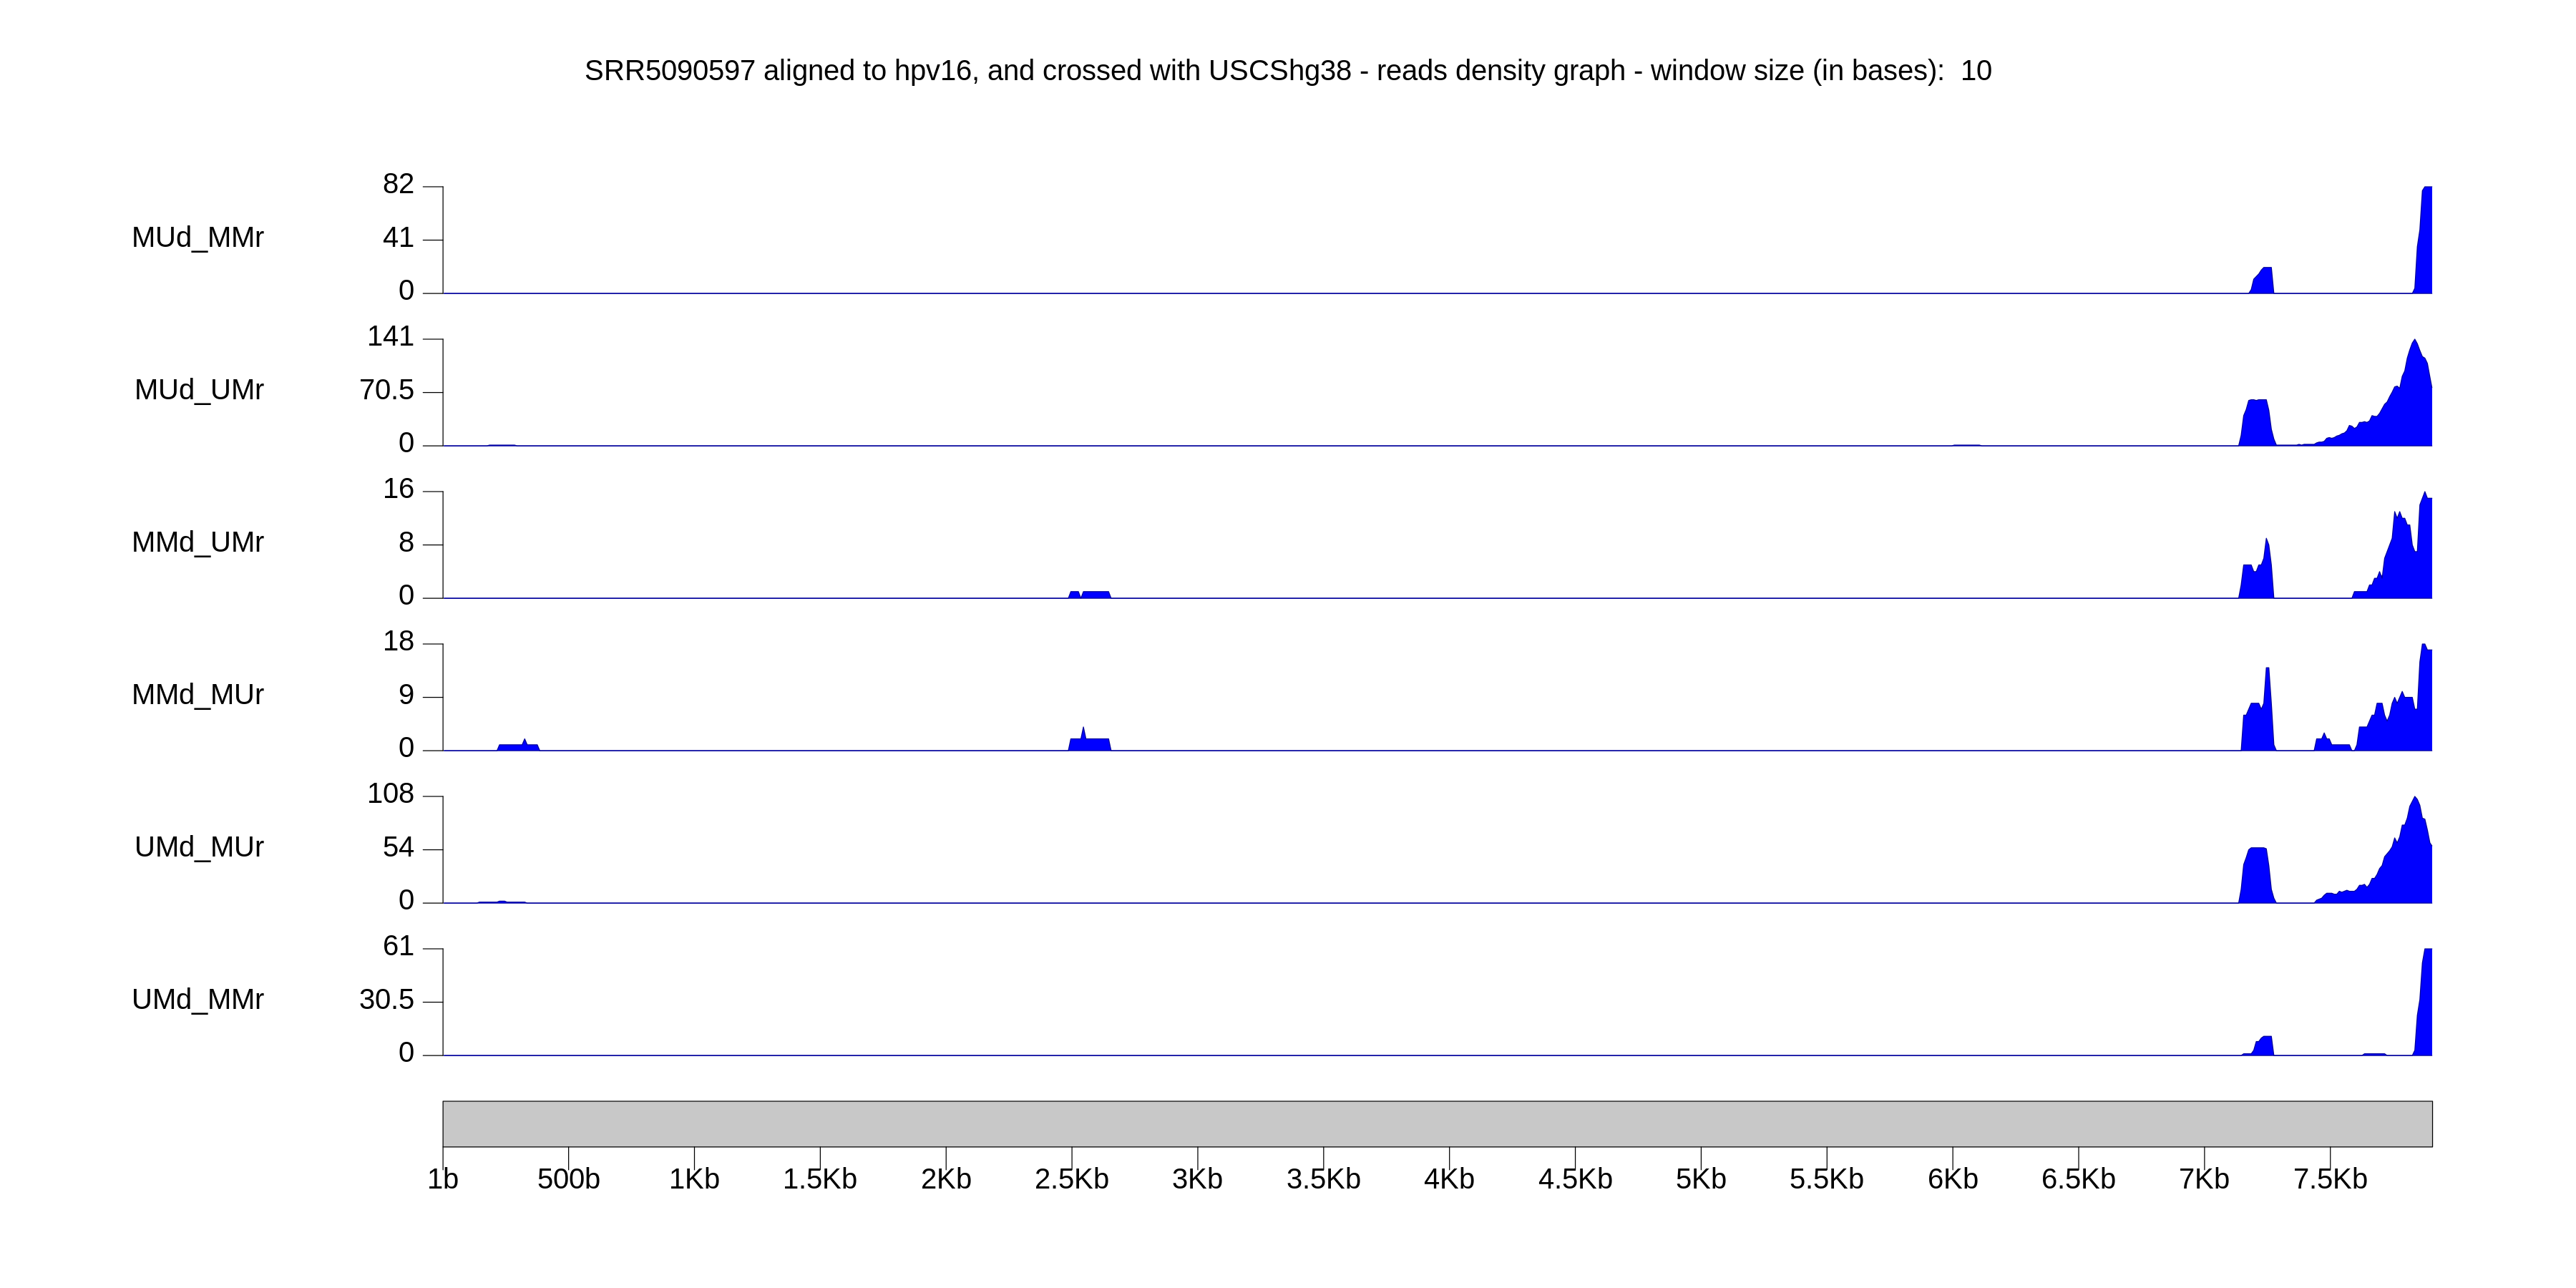

In [34]:
options(repr.plot.width=30, repr.plot.height=15)
create_viz(graph_type="donor", 
           ref_genome=donor_ref_genome, 
           granges = list(donor_UMd_MMr, donor_UMd_MUr, donor_MMd_MUr, donor_MMd_UMr, donor_MUd_UMr, donor_MUd_MMr), 
           granges_labels = list("UMd_MMr", "UMd_MUr",  "MMd_MUr", "MMd_UMr", "MUd_UMr", "MUd_MMr"),
           title_prepend = paste(srr_name, ' aligned to ', donor_name, ', and crossed with ', recipient_name, sep = ""))

In [35]:
min_num_crossings <- 2
granges <- list(donor_UMd_MMr, donor_UMd_MUr, donor_MMd_MUr, donor_MMd_UMr, donor_MUd_UMr, donor_MUd_MMr)
granges_labels <- list("UMd_MMr", "UMd_MUr",  "MMd_MUr", "MMd_UMr", "MUd_UMr", "MUd_MMr")
print_summary_table(table_type = "donor", granges, granges_labels, min_num_crossings = 2)

chr,start,stop,num_crossings,unique_crossings,num_reads
NC_001526.4,7377,7906,6,"UMd_MMr, UMd_MUr, MMd_MUr, MMd_UMr, MUd_UMr, MUd_MMr",650
NC_001526.4,7143,7371,6,"UMd_MMr, UMd_MUr, MMd_MUr, MMd_UMr, MUd_UMr, MUd_MMr",177
NC_001526.4,2494,2645,2,"MMd_MUr, MMd_UMr",6
NC_001526.4,150,375,3,"UMd_MUr, MMd_MUr, MUd_UMr",5


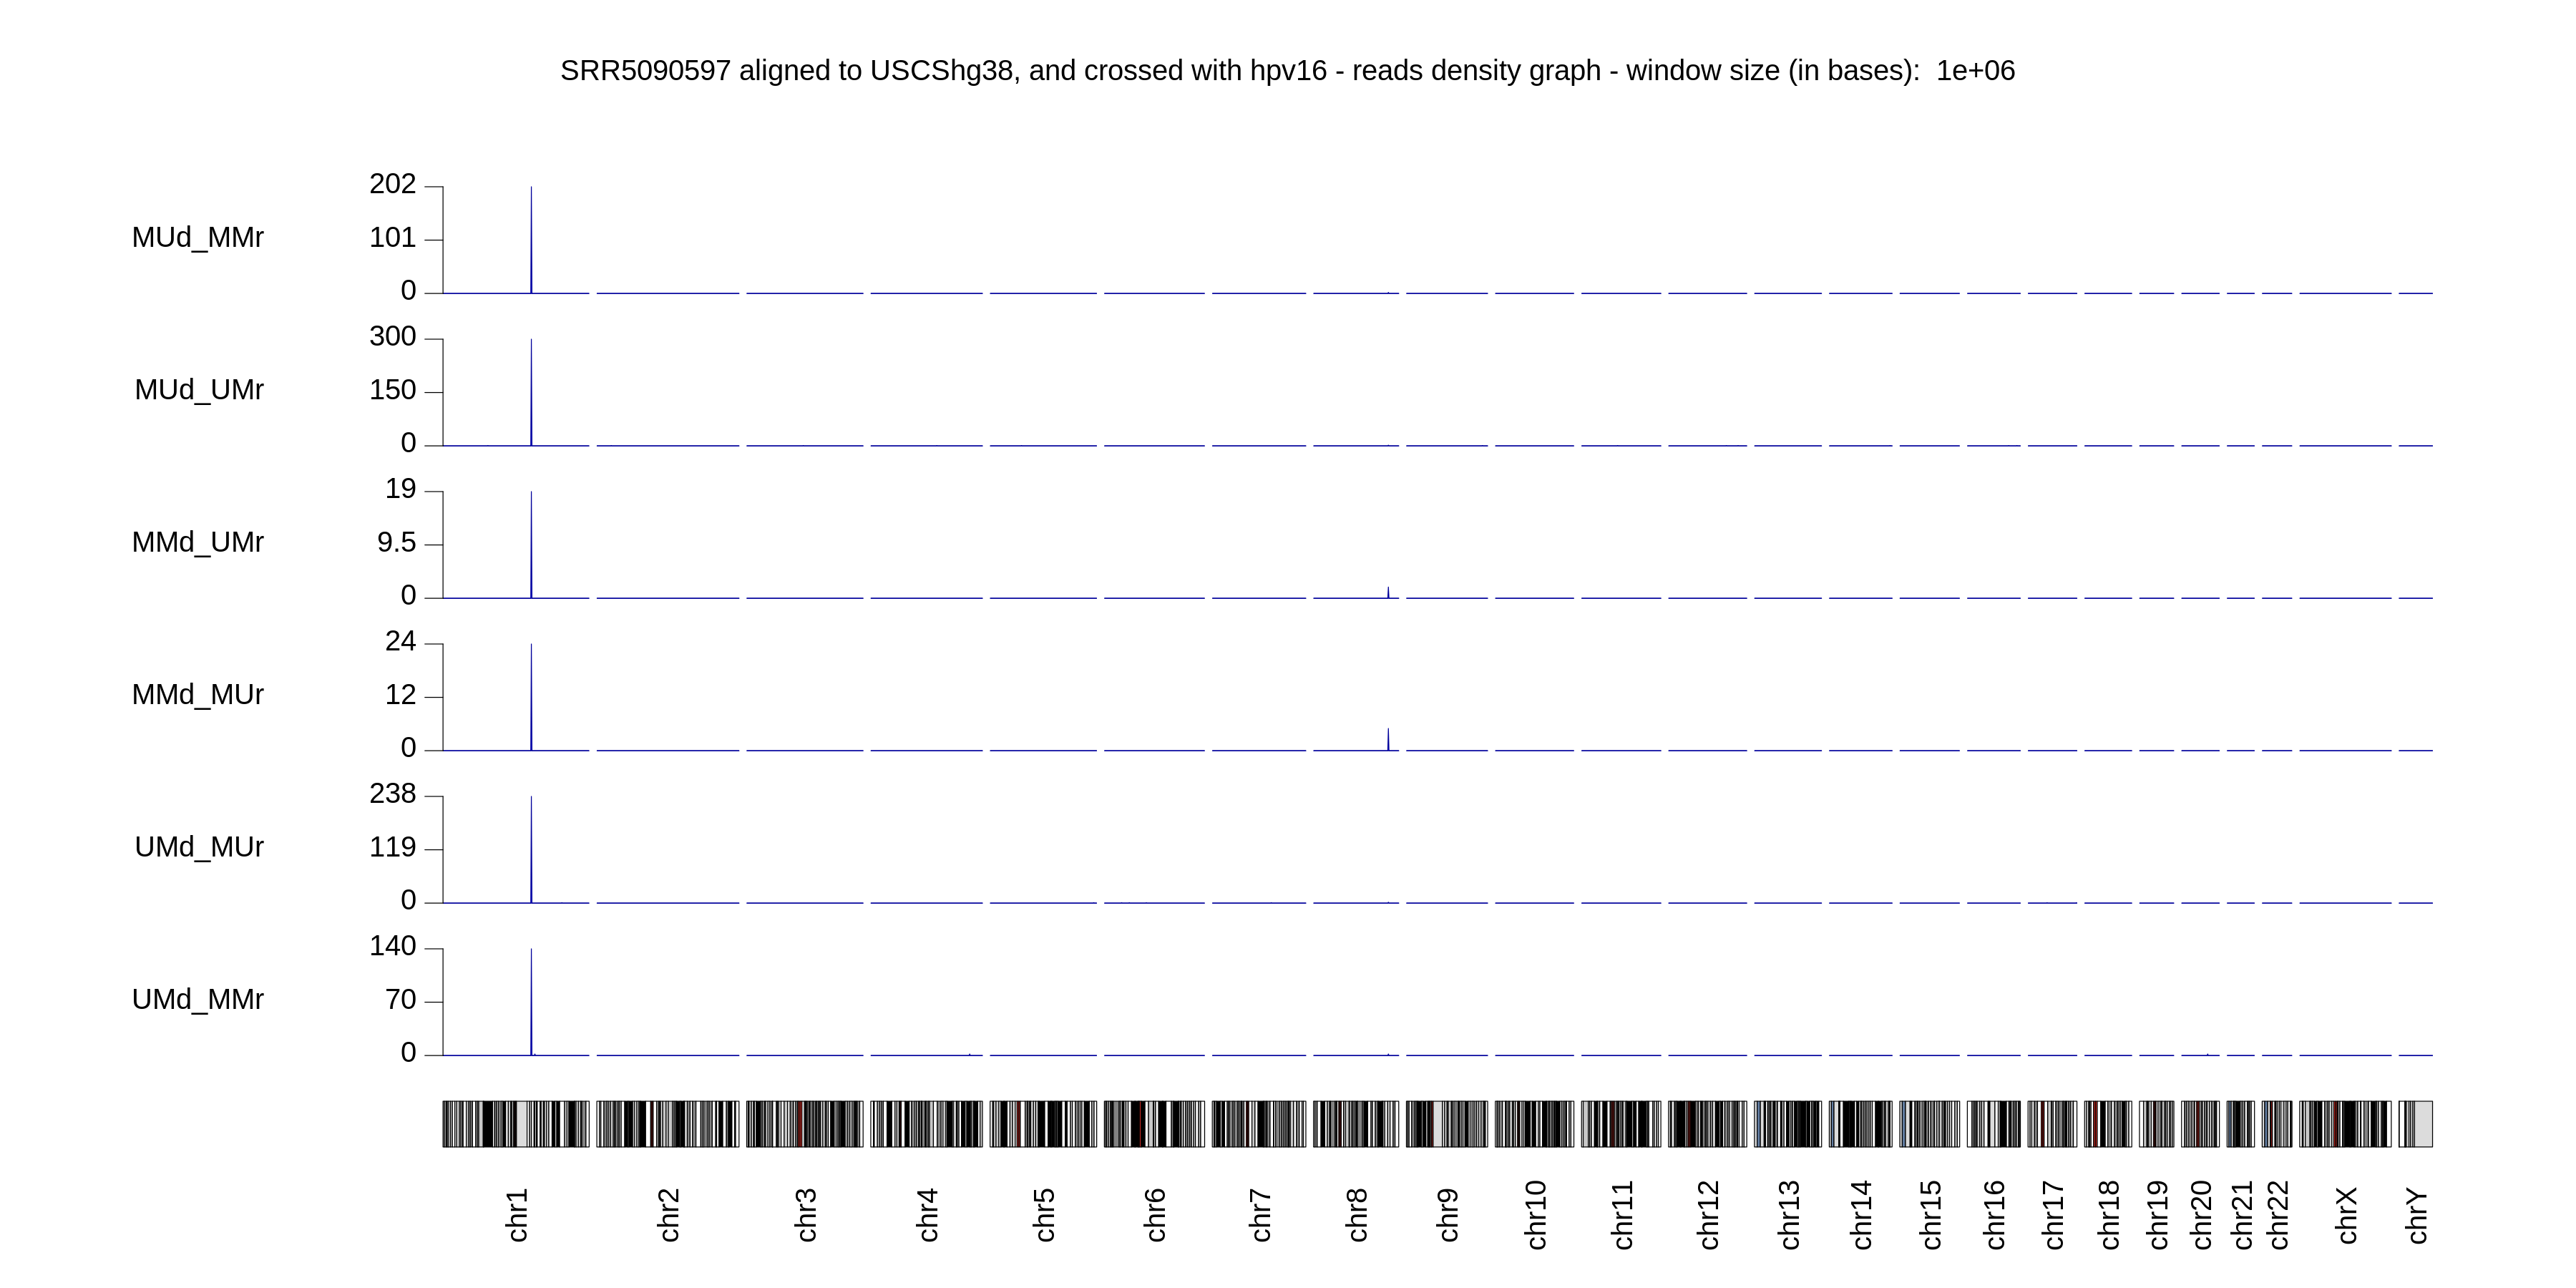

In [36]:
options(repr.plot.width=30, repr.plot.height=15)
create_viz(graph_type="recipient", 
           ref_genome="hg38", 
           granges = list(recip_UMd_MMr, recip_UMd_MUr, recip_MMd_MUr, recip_MMd_UMr, recip_MUd_UMr, recip_MUd_MMr), 
           granges_labels = list("UMd_MMr", "UMd_MUr",  "MMd_MUr", "MMd_UMr", "MUd_UMr", "MUd_MMr"),
           title_prepend = paste(srr_name, ' aligned to ', recipient_name, ', and crossed with ', donor_name, sep = ""))

In [37]:
min_num_crossings <- 2
granges <- list(recip_UMd_MMr, recip_UMd_MUr, recip_MMd_MUr, recip_MMd_UMr, recip_MUd_UMr, recip_MUd_MMr)
granges_labels <- list("UMd_MMr", "UMd_MUr",  "MMd_MUr", "MMd_UMr", "MUd_UMr", "MUd_MMr")
print_summary_table(table_type = "recipient", granges, granges_labels, min_num_crossings = 2)

chr,start,stop,num_crossings,unique_crossings,num_reads,tx_id,tx_name,sequence
chr1,150578243,150578495,6,"UMd_MMr, UMd_MUr, MMd_MUr, MMd_UMr, MUd_UMr, MUd_MMr",528,"15925, 15926, 15927","ENST00000620947.4, ENST00000369026.3, ENST00000464132.1",CCCAGCCTCTTTGTTTAACTAGCCAGTCCCGTTTTGTCCTTACGAGAACGTCTGTGATACTTTCTGCTAATGGTTCGATGCAGCTTTCTTGGTTTATGGTCTTCAAGTGTTTAGCCACAAAGGCACCAAAAGAAATGAGAGTCACAATCCTGCCCCAGTTTGTTACGCCGTCGCTGAAAACATGGATCATCACTCGAGACAACGATTTCACATCGTCTTCGTTTTTGATGTCCAGTTTCCGAAGCATGCCTGA
chr1,150576896,150577494,6,"UMd_MMr, UMd_MUr, MMd_MUr, MMd_UMr, MUd_UMr, MUd_MMr",386,"15925, 15926, 15927","ENST00000620947.4, ENST00000369026.3, ENST00000464132.1",GCTTCCCTTGTACAGTACTGAGGCTTACAGTCATAGTTCTATTACTTGTAACTTTTACACAGGTCACTGGCATTCTTAGTGCTTCTCTTAACACTACAGTAAATTAATGAATTCGGCGGGTAATCAATTCTATGACTTGCCTGGCTACTGGCCACTTTCCTGTTCTCAACAAGGAAATTAAGTCTTTCCACCCTACCATCTTCACTAAATCTAAAAGTCCTCCTCCATAGCTTCCCAAACAAAGTTTGTTTGTTGCTGAAACTGAACTTTGCTTCTTTCAGACAGTGACTCTTCAATCAATGGGGAGCACTCTTCCCATGTATTTATTCTTGTTAGCCATAATCCTCTTGCCACTTGCTTTTCTGGCTAGGTTGCTAGGGTGCAACTCTAGGAAGTTACAGCTTGGAGTCCAACTGCATAAACTGGTTTTGGTGGTGGTGGTGGTTGGTTAAAAGTCAACTATTGCACTTACAGTAAGGCTATCTTATTAGATATGCCAAACCAGCTCCTACTCCAGCAACACCTGCAAAAGCCAGCAGCACATTCCTGATGCCACCTTCTAGGTCCTCTACATGGAAGAACTCCACAAACCCATCCTA
chr8,127828232,127828354,5,"UMd_MMr, UMd_MUr, MMd_MUr, MMd_UMr, MUd_MMr",6,"95998, 95999, 96000","ENST00000667305.1, ENST00000664214.1, ENST00000653522.1",GCTTCTTACTGAGTGTCTAGTTCCTTGTTGTACAGGTGAGGGAAACTGAGGCCCAGAGTGGATGTGACGTTTCCGAAGGAGAGGCTCTGTAAAGTTCTGAGTAGGTGAGACTTATTATTAGCT
chr1,150576721,150576860,2,"UMd_MUr, MUd_UMr",6,"15925, 15926","ENST00000620947.4, ENST00000369026.3",AGGATATCCATATTCATAACTAATTACTGAGCCTTCCGTCAAGTATTATTGGTGATAAACTAGGCTAATAAAGTAAGAATCATGGAAACCAAGCCAAAGTATAACAGGTATAAAAGTCCTGAACACTTGGACTTTCTAAG
chr8,127828082,127828207,3,"UMd_MMr, UMd_MUr, MUd_UMr",4,"95998, 95999, 96000","ENST00000667305.1, ENST00000664214.1, ENST00000653522.1",GGCAGGGTGTGTATCTTCTTGCTGCTGGGATGTTCTACTTTGTTGGACAGAAGGCTATGTGCTTTCTGGCAGGTTACACCTGGGTACATTTCAGTCAAGCCGAGCTGGCTCTCTCCTCATTTCATT
chr1,150571451,150571524,2,"UMd_MUr, MUd_UMr",2,15921,ENST00000617352.1,CCTCAATGTTGAAGATTTCTCATTTCCCAATGGAAAATAACTATTATTCTATGCAGGTCAAGAAGGGAACTGCA


In [38]:
deparse(substitute(recip_UMd_MUr))

[1] "recip_UMd_MUr"

In [40]:
min_num_crossings <- 2
granges <- list(donor_UMd_MMr, donor_UMd_MUr, donor_MMd_MUr, donor_MMd_UMr, donor_MUd_UMr, donor_MUd_MMr)
granges_labels <- list("UMd_MMr", "UMd_MUr",  "MMd_MUr", "MMd_UMr", "MUd_UMr", "MUd_MMr")

granges_df <- lapply(granges, annoGR2DF)
names(granges_df) <- granges_labels
merged_df <- bind_rows(granges_df, .id = "crossing")
merged_dt <- as.data.table(merged_df)

## Interval per chromosome
merged_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) }, by = chr]
merged_final <- merged_dt[, list(start=min(start), 
                                 stop=max(end), 
                                 num_crossings=length(unique(list(crossing)[[1]])),
                                 unique_crossings=list(unique(crossing)),
                                 num_reads=length(list(name)[[1]])
                                 ), by=list(group,chr)]
merged_final <- merged_final[merged_final[, num_crossings > (min_num_crossings - 1)]]

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
Hsapiens <- BSgenome.Hsapiens.UCSC.hg38

In [43]:
transcripts(txdb)

GRanges object with 247541 ranges and 2 metadata columns:
                   seqnames        ranges strand |     tx_id           tx_name
                      <Rle>     <IRanges>  <Rle> | <integer>       <character>
       [1]             chr1   11869-14409      + |         1 ENST00000456328.2
       [2]             chr1   12010-13670      + |         2 ENST00000450305.2
       [3]             chr1   29554-31097      + |         3 ENST00000473358.1
       [4]             chr1   30267-31109      + |         4 ENST00000469289.1
       [5]             chr1   30366-30503      + |         5 ENST00000607096.1
       ...              ...           ...    ... .       ...               ...
  [247537] chrUn_GL000220v1 155997-156149      + |    247537 ENST00000619779.1
  [247538] chrUn_KI270442v1 380608-380726      + |    247538 ENST00000620265.1
  [247539] chrUn_KI270442v1 217250-217401      - |    247539 ENST00000611690.1
  [247540] chrUn_KI270744v1   51009-51114      - |    247540 ENST00000616

In [48]:
a <- transcripts(txdb)
b <- donor_UMd_MMr


Warning message in system("ls fizzlipuzzli", intern = TRUE, ignore.stderr = TRUE):
"running command 'ls fizzlipuzzli 2>/dev/null' had status 2"


character(0)
attr(,"status")
[1] 2
attr(,"errmsg")
[1] "Resource temporarily unavailable"

In [49]:
try(system("ls fizzlipuzzli", intern = TRUE, ignore.stderr = TRUE))

Warning message in system("ls fizzlipuzzli", intern = TRUE, ignore.stderr = TRUE):
"running command 'ls fizzlipuzzli 2>/dev/null' had status 2"


character(0)
attr(,"status")
[1] 2
attr(,"errmsg")
[1] "Resource temporarily unavailable"